<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/TempModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install firebase-admin
import pandas as pd
import os 
import math
import cv2
import numpy as np 
import csv
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt 
import warnings
from sklearn.model_selection import cross_val_predict, cross_val_score

In [0]:
warnings.simplefilter('ignore')

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/croppedimg.zip'  #change dir to your project folder


In [0]:
!unzip gdrive/My\ Drive/croppedimg.zip

In [0]:
dir = os.listdir('/content/')
print(dir)
shanghai=[]
for file in dir:
  if(file.endswith('.jpg') and file[:4]=='2014'):
    print(file)
    shanghai.append('/content/' + str(file))
    
   

In [0]:
im_trans_=[]
im_cont_=[]
im_ent_=[]
im_read_=[]
shanghai.sort()

print(shanghai)

for img in shanghai:
  im = cv2.imread(img)
  im = cv2.resize(im,(128,128))
  im_read_.append(im)
  im_trans_.append(np.ndarray.flatten(transmission(im, retMean = False)))
  im_ent_.append(entropy(im))
  im_cont_.append(contrast(im))
 


In [0]:
import datetime
import firebase_admin
from firebase_admin import credentials
from firebase_admin import storage

# Fetch the service account key JSON file contents
cred = credentials.Certificate("credentials.json")

# Initialize the app with a service account, granting admin privileges
app = firebase_admin.initialize_app(cred, {
    'storageBucket': 'fir-4ca2c.appspot.com',
}, name='storage')

In [0]:
def transmission(img, lt = 230, retMean = False):
  ker = np.ones((3, 3))/9.0
  imgrgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  b, g, r = cv2.split(img)
  hsv = cv2.cvtColor(imgrgb, cv2.COLOR_RGB2HSV)
  _, _, v = cv2.split(hsv)
  v_blur = cv2.filter2D(v, -1, ker)
  _,building_mask = cv2.threshold(v_blur, lt, 255, cv2.THRESH_BINARY)
  sky = cv2.bitwise_and(imgrgb, imgrgb, mask = building_mask)
  sky_mask = cv2.bitwise_not(building_mask, building_mask.copy())
  building = cv2.bitwise_and(imgrgb, imgrgb, mask = sky_mask)
 
  al = max(v_blur.flatten())
  #Airlight Found. Now calculate Transmission Map
  img_norm = img/float(al)
  b, g, r = cv2.split(img_norm)
  kernel = np.ones((3,3),np.uint8)
  im_new = np.zeros((img.shape[0], img.shape[1]))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      im_new[i][j] = min(b[i][j], g[i][j], r[i][j])
  dcp = cv2.erode(im_new, kernel, iterations = 1)
  #ax[3].imshow(im_new, cmap = 'gray')
  #ax[4].imshow(dcp, cmap = 'gray')
  tr = np.ones((dcp.shape[0], dcp.shape[1]))
  for i in range(dcp.shape[0]):
    for j in range(dcp.shape[1]):
      tr[i][j] = 1 - dcp[i][j]
  #ax[1].imshow(tr, cmap = 'gray')
  if retMean == False:
    return tr
  elif retMean == True:
    return np.mean(tr)

In [0]:
def entropy(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  hist = cv2.calcHist( [image.astype('float32')],
              [0], 
              None,
               [256], 
              [0,256] )
  h_norm = 0
  h_norm = cv2.normalize(hist, h_norm)
  ent = 0
  for p in h_norm:
    try:
      ent += p*math.log(p, 2)
    except:
      pass
    
  return (-1 * ent[0])

In [0]:
def contrast(image):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  s = 0
  ss = 0
  mean = np.mean(image)
  x = (-1 * mean * (np.ones(image.shape)))
  ss = np.square(np.add(image, x))
  cont = np.sqrt(np.sum(ss)/float(image.size))
  return cont

In [0]:
#Loading E1 - Lenovo data : - sscb labels 
# until 14:43 - lenovo hold sscb photographs 
# 16:09 onwards - DTU Photographs 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imglenovo = [] #has all the lenovo images by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:16]=="lenovoinS" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
      blob.download_to_filename('/content/' + "lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
      imglenovo.append("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg') 
      print("lenovo" + str(blob.name.split('/')[-1])+ '.jpeg')
      ctr+=1
      print(ctr)


In [0]:
# Loading E2 - Mi data : 760 -- sscb labels 
# all SSCB photos 

bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgminote = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name[7:16]=="minoteSSC" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        blob.download_to_filename('/content/' + "minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgminote.append("minote" + str(blob.name.split('/')[-1])+ '.jpeg') 
        print("minote" + str(blob.name.split('/')[-1])+ '.jpeg')
        ctr+=1
      
      

print(ctr)

In [0]:
bucket = storage.bucket(app=app)
blobs = bucket.list_blobs()

imgpb = [] #has all the minote pictures by their name 
ctr=0
mits = set()
for blob in blobs:
  if blob.name.split('/')[1]=="rivers.jpg" :
    if int(blob.name[-8:-6])<19 and int(blob.name[-8:-6])>5:
        print(blob.name)

        blob.download_to_filename('/content/' + "pb" + str(blob.name.split('/')[-1])+ '.jpeg')
        imgpb.append("pb" + str(blob.name.split('/')[-1])+ '.jpeg') 
        print("pb" + str(blob.name.split('/')[-1])+ '.jpeg')
        ctr+=1
        print(ctr)

In [0]:
print(len(imgminote))
print(len(imglenovo))
print(len(imgpb))
print(len(shanghai))

imgminote = np.reshape(imgminote,(len(imgminote),1))
imglenovo = np.reshape(imglenovo,(len(imglenovo),1))
imgpb = np.reshape(imgpb,(len(imgpb),1))
#shanghai = np.reshape(shanghai,(len(shanghai),1))

875
881
483
1953


In [0]:
print(imgminote[0])
print(imglenovo[0])
print(imgpb[0])
print([shanghai[0]])


print(np.shape(imgminote))
print(np.shape(shanghai))

['minote2019-06-27 15:14:35.jpeg']
['lenovo2019-06-27 17:01:04.jpeg']
['pb2019-07-03 12:46:45.jpeg']
[array(['/content/201405061100.jpg'], dtype='<U29')]
(875, 1)
(1953, 1)


In [0]:
#Ready to stack into a common image 

images = np.vstack((imgminote,imglenovo, imgpb))

In [0]:
print(images)

[['minote2019-06-27 15:14:35.jpeg']
 ['minote2019-06-27 15:15:34.jpeg']
 ['minote2019-06-27 15:16:22.jpeg']
 ...
 ['pb2019-07-04 14:35:07.jpeg']
 ['pb2019-07-04 14:36:07.jpeg']
 ['pb2019-07-04 16:15:54.jpeg']]


In [0]:
im_trans=[]
im_ent=[]
im_cont=[]
im_read=[]

for img in images:
  print(img[0])  
  im = cv2.imread(img[0])
  im = cv2.resize(im,(128,128))
  im_read.append(im)
  im_trans.append(np.ndarray.flatten(transmission(im, retMean = False)))
  im_ent.append(entropy(im))
  im_cont.append(contrast(im))
  

In [0]:
print(len(im_trans))
print(len(im_cont))
print(len(im_ent))
print(len(images))

In [0]:
ctr=0
dict={}

for img in images:
  l=[]
  l.append(im_trans[ctr])
  l.append(im_cont[ctr])
  l.append(im_ent[ctr])
  dict[(img[0])]=l  
  ctr+=1

In [0]:
print(len(dict))
print(dict)

2239
{'minote2019-06-27 15:14:35.jpeg': [array([0.92156863, 0.92156863, 0.92156863, ..., 0.92941176, 0.92941176,
       0.91764706]), 56.17309332041681, 45.37183380126953], 'minote2019-06-27 15:15:34.jpeg': [array([0.78151261, 0.78151261, 0.77731092, ..., 0.90336134, 0.90336134,
       0.89915966]), 51.6164646242046, 44.63212966918945], 'minote2019-06-27 15:16:22.jpeg': [array([0.88669951, 0.89162562, 0.90147783, ..., 0.97044335, 0.97044335,
       0.96551724]), 22.768425712162884, 24.338146209716797], 'minote2019-06-27 15:16:40.jpeg': [array([0.63636364, 0.72727273, 0.72727273, ..., 0.72727273, 0.68181818,
       0.63636364]), 2.4961889596550044, 5.14749002456665], 'minote2019-06-27 15:16:57.jpeg': [array([0.73913043, 0.73913043, 0.82608696, ..., 0.82608696, 0.82608696,
       0.73913043]), 2.482789666657217, 5.100596904754639], 'minote2019-06-27 15:19:21.jpeg': [array([0.90588235, 0.90588235, 0.90588235, ..., 0.88235294, 0.89019608,
       0.89019608]), 38.702523187508085, 31.8431377

In [0]:
tmp=[]
for key in dict:
  temp=key[-24:-5]
  temp=temp.split('-')
  
  newtemp=temp[2].split(' ')
  
  newesttemp=newtemp[1].split(':')
  j=int(newesttemp[1])
  #print(j)
  if(j<=7.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  elif(j<=15 or j<=22.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '15'
  elif(j<=30 or j<=37.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '30'
  elif(j<=45 or j<=52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '45'
  elif(j>52.5):
    final = newtemp[0] + '-' + temp[1] + '-' + temp[0] + ' ' + newesttemp[0] + ':' + '00'
  tmp.append(final)
  
  
print(len(tmp))

2239


In [0]:
##Modified timestamp with e,c,t

i=0
ecttime=[]
for key in dict:
  l=[]
  l.append(tmp[i])
  l.append(dict[key])
  ecttime.append(l)
  i+=1

In [0]:
##DROPPING NONE VALUES


df = pd.read_csv('/content/labels.csv')
data = df.mask(df.eq('None')).dropna()
file = data.to_csv('/content/labels_new.csv')


df_ = pd.read_csv('/content/labels_pb.csv')
data_ = df_.mask(df.eq('None')).dropna()
file_ = data_.to_csv('/content/labels_pb_new.csv')


In [0]:
k=0
cpcb=[]


with open('/content/labels_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>=3):
      l=[]
      l.append(row[2])
      l.append(row[4]) #PM
      l.append(row[3]) #RH
      cpcb.append(l)      

    
    

with open('/content/labels_pb_new.csv') as file:
  reader = csv.reader(file, delimiter =',')
  for row in reader:
    k+=1
    if(k>=3):
      l=[]
      l.append(row[2])
      l.append(row[4]) #PM
      l.append(row[3]) #RH
      cpcb.append(l)      

In [0]:
print(len(cpcb))
for ele in cpcb:
  print(ele)
  break


989
['27-06-2019 00:15', '61', '0.3']


In [0]:
final=[]
for e in ecttime:
  for tmp in cpcb:
    if(tmp[0] == e[0]):
      l=[]
      l.append(tmp[0])
      l.append(e[1])
      l.append(tmp[2])
      l.append(tmp[1])
      final.append(l)
      break


In [0]:
print(len(final))

1939


In [0]:
print(final[0])

['27-06-2019 15:15', [array([0.92156863, 0.92156863, 0.92156863, ..., 0.92941176, 0.92941176,
       0.91764706]), 56.17309332041681, 45.37183380126953], '0.3', '47']


In [0]:
import pickle 
with open('/shanghai_data.bin', 'rb') as file:
  data = pickle.load(file)

In [0]:
features = np.array(data[0])
labels = np.array(data[1])
print(np.shape(features), np.shape(labels))
print(labels[0])




(1542, 259) (1542,)
26.0


In [0]:
print(data[0])
print(data[1])

[[0.08108108 0.08108108 0.09009009 ... 0.59019669 0.4641165  0.61396847]
 [0.22580645 0.22580645 0.22119816 ... 0.15210725 0.26043559 0.53446094]
 [0.11453744 0.11453744 0.11013216 ... 0.57783903 0.35867383 0.51593603]
 ...
 [0.13191489 0.13191489 0.13191489 ... 0.42499362 0.59138912 0.47819583]
 [0.07964602 0.07964602 0.07522124 ... 0.52378471 0.48524375 0.19249799]
 [0.11297071 0.11715481 0.11715481 ... 0.59710812 0.74194161 0.60683466]]
[26.0, 31.0, 59.0, 45.0, 9.0, 51.0, 43.0, 150.0, 43.0, 13.0, 30.0, 21.0, 38.0, 99.0, 78.0, 42.0, 92.0, 47.0, 13.0, 47.0, 24.0, 83.0, 43.0, 41.0, 23.0, 37.0, 21.0, 27.0, 75.0, 38.0, 77.0, 38.0, 61.0, 56.0, 45.0, 97.0, 17.0, 53.0, 29.0, 29.0, 3.0, 69.0, 90.0, 34.0, 16.0, 38.0, 44.0, 24.0, 25.0, 27.0, 12.0, 16.0, 32.0, 30.0, 89.0, 34.0, 49.0, 135.0, 43.0, 55.0, 54.0, 41.0, 6.0, 43.0, 29.0, 21.0, 43.0, 34.0, 17.0, 43.0, 58.0, 47.0, 109.0, 38.0, 53.0, 12.0, 49.0, 27.0, 40.0, 38.0, 84.0, 22.0, 43.0, 36.0, 14.0, 130.0, 37.0, 40.0, 30.0, 38.0, 32.0, 22.0, 43

In [0]:
#Feature engineering
hours=[]
trans=[]
cont=[]
ent=[]
rh=[]
pm=[]


## OUR OWN DATA 
for e in final:
  hours.append(float(e[0][-5:-3]))
  pm.append(float(e[3]))
  trans.append(e[1][0])
  ent.append(float(e[1][2]))
  cont.append(float(e[1][1]))
  rh.append(e[2])
  
  
  
  
##SHANGHAI'S DATA 

  

In [0]:
print(len(hours))
print(hours)
print(len(trans))
# print(trans)
print(len(cont))
print(cont)
print(len(ent))
print(ent)
print(len(rh))
print(rh)
print(len(pm))
print(pm)

1939
[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 18.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 11.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 14.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 17.0, 17.0, 17.0,

In [0]:
final_shape=len(hours)

hours = np.reshape(hours,(final_shape,1))
# trans = np.reshape(trans,(final_shape,1))
cont = np.reshape(cont,(final_shape,1))
ent = np.reshape(ent,(final_shape,1))
pm = np.reshape(pm,(final_shape,1))
rh = np.reshape(rh,(final_shape,1))
features = np.hstack((hours, cont, ent, rh, trans))

print(features[0])


scaler = MinMaxScaler()

hours = scaler.fit_transform(hours)
trans = scaler.fit_transform(trans)
cont = scaler.fit_transform(cont)
ent = scaler.fit_transform(ent)
rh = scaler.fit_transform(rh)



features = np.hstack((hours, cont, ent,rh, trans))

print(features[0])

['15.0' '56.17309332041681' '45.37183380126953' ... '0.9294117647058824'
 '0.9294117647058824' '0.9176470588235294']
[0.75       0.6167729  0.81927261 ... 0.92498022 0.9243013  0.91168485]


17.502437639467338
10.489469842697938


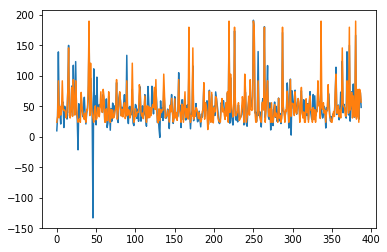

In [0]:
reg = LinearRegression(normalize =False)
cross = cross_val_score(reg, features, pm, scoring ='neg_mean_squared_error',cv=3)
x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.2, random_state =42)

reg.fit(x_train, y_train)

pred = reg.predict(x_test)

plt.plot(pred)
plt.plot(y_test)

print(mean_squared_error(pred, y_test)**0.5)
print(mean_absolute_error(pred, y_test))



In [0]:
print(((-1)*cross)**0.5)

[105.05873055  48.69930969  55.34920108]


In [0]:
shape = np.shape(pred)

pred = np.reshape(pred, shape)
y_test = np.reshape(y_test, shape)
result = np.hstack((pred, y_test))
print(result)


In [0]:
print(max(np.diff(result)))
print(min(np.diff(result)))

16.554966717851315
10.720760196933275


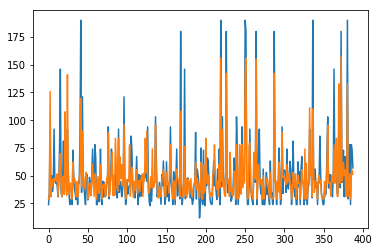

In [0]:
x_train, x_test, y_train, y_test = train_test_split(features, pm, test_size =0.2, random_state =42)
from sklearn.model_selection import GridSearchCV

reg = RandomForestRegressor(max_depth=3)
clf = GridSearchCV(reg, {}, cv=5)
clf.fit(x_train, y_train)
pred = clf.predict(x_test)


plt.plot(y_test)
plt.plot(pred)
print(mean_squared_error(pred, y_test)**0.5)
print(mean_absolute_error(pred, y_test))

In [0]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

In [0]:
print(clf)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=3, max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None, param_grid={}, pre_dispatch='2*n_jobs',
             refit=True, return_train_score=False, scoring=None,

In [0]:
k = (np.shape(pred))[0]
for i in range(0, ):
  print(str(y_test[i]) + '\t' + str(pred[i]))

In [0]:
k = (np.shape(pred))[0]
for i in range(0,k ):
  print(str(y_test[i]) + '\t' + str(pred[i]))

[24.]	29.576150600580366
[34.04]	31.408337664456486
[92.]	117.68626881260536
[31.09]	30.39164070217688
[50.]	45.52806879842137
[35.77]	39.52211622620162
[42.31]	44.39615856040428
[92.]	44.84602511455299
[46.]	48.9273383524564
[43.27]	44.39615856040428
[44.]	46.9504352580487
[41.]	56.872704153080555
[31.09]	31.262419616524944
[45.]	44.211245366630195
[75.]	53.275758219262094
[146.]	62.13950358773693
[34.95]	45.52806879842137
[31.]	31.262419616524944
[50.]	49.54965631954384
[81.2]	45.15773576624664
[33.56]	31.408337664456486
[94.]	86.32074992173891
[55.]	47.79347161956921
[35.77]	33.06208975475543
[92.]	132.0033246014346
[56.]	53.33092448404983
[34.7]	36.551020024276696
[24.]	57.316166996015795
[27.]	45.52806879842137
[29.15]	29.576150600580366
[24.]	29.576150600580366
[73.]	59.68079083239699
[51.]	44.59899385241121
[38.]	45.229899823142446
[33.77]	44.88670532095952
[28.6]	32.88627452584326
[39.]	45.52806879842137
[24.]	29.576150600580366
[45.]	39.881158792104614
[43.27]	45.9822873881683

In [0]:
'''explained_variance	metrics.explained_variance_score	 
‘max_error’	metrics.max_error	 
‘neg_mean_absolute_error’	metrics.mean_absolute_error	 
‘neg_mean_squared_error’	metrics.mean_squared_error	 
‘neg_mean_squared_log_error’	metrics.mean_squared_log_error	 
‘neg_median_absolute_error’	metrics.median_absolute_error	 
‘r2’	metrics.r2_score'''


score = cross_val_score(reg,features,pm,cv=5,scoring ='neg_mean_squared_error')
print(score)

[-1895.37173806 -1502.67705747 -1353.50640106  -367.31680843
 -1301.74239144]
